# Image model training
## Imports

In [1]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from joblib import dump
from IPython.display import clear_output

from image_model_training import *

## Parámetros
Se establecen los parámetros para el entrenamiento.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"

data_origin = MICRO
clear_training_prints = False

if data_origin == MICRO:
    data_dir = f"{project_dir}/samples/microcontroller/preprocessed image/train"
    augment = True
    origin_name = "Micro"
    epochs = 500
    early_stopping_patience = 50

else:
    data_dir = f"{project_dir}/samples/external/preprocessed image/train"
    augment = False
    origin_name = "Ext"
    epochs = 100 # Por limitaciones de RAM no se pueden entrenar demasiados epochs.
    early_stopping_patience = 20

input_shape = (*IMG_SIZE, 1)

model_name = f"{origin_name}{DATA_TYPE}DataModel"

log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
checkpoint_dir = f"{saved_models_dir}/tensorflow/checkpoints"
checkpoint_path = f"{checkpoint_dir}/{model_name}.hdf5"

validation_percentage = 20.

initial_learning_rate = 0.001
decay = (initial_learning_rate / epochs) * 1.5

## Carga de datos
Se generan datasets de entrenamiento, validación y test a partir de las imágenes recolectadas.

In [3]:
train_dataset, validation_dataset = get_image_datasets(data_dir, validation_percentage)
class_names = train_dataset.class_names

Found 274 files belonging to 3 classes.
Using 220 files for training.
Found 274 files belonging to 3 classes.
Using 54 files for validation.


Aplicamos o no data augmentation que consiste en aplicar pequeñas rotaciones, zoom o hacer flips horizontales de la
imagen.

In [4]:
if augment:
    train_dataset = augment_data(train_dataset, input_shape)
    validation_dataset = augment_data(validation_dataset, input_shape)

Comprobamos el contenido de los datasets. Primero listamos las classes y luego mostramos una pequeña muestra del
conjunto training.

Aprovechamos para guardar la correspondencia entre las labels del dataset y su nombre.

Classes:
	0: face
	1: mask
	2: nothing


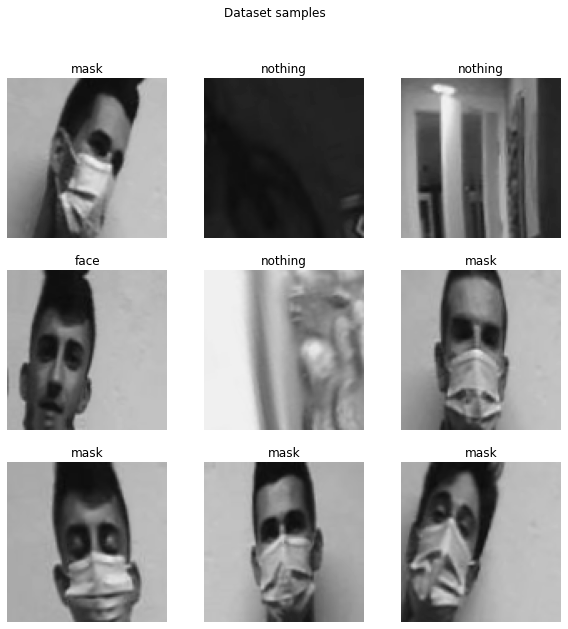

In [5]:
class_list_text = "Classes:"
for index, name in enumerate(class_names):
    class_list_text += f"\n\t{index}: {name}"
    
print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(class_names, f"{label_index_dir}/{model_name}.joblib")

demo_image_dataset(train_dataset, class_names=class_names)

Ajustamos la configuración de los datasets para entrenamiento para evitar cuellos de botella en su lectura.

In [6]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Normalizamos el dataset para que los datos tengan valores en [-1, 1] que funcionan mejor para entrenar el modelo.py

Esta operación ahora se realiza en el inicio del modelo.

In [7]:
# train_dataset = normalize_dataset(train_dataset)
# validation_dataset = normalize_dataset(validation_dataset)

## Creación del modelo

Se crea el modelo que se entrenará. Visualizamos la estructura del modelo creado, donde se ve también el número de
parámetros.

In [8]:
model = get_image_model(len(class_names), model_name)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "MicroImgDataModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 97, 97, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 4)         36        
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 48, 48, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 8)         288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 8)   

## Entrenamiento del modelo

Se entrena el modelo creado con los datos de entrenamiento y validación. Se cargan los pesos del checkpoint que ha
obtenido mayor validation accuracy.

In [9]:
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                            mode='max', save_best_only=True, verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=early_stopping_patience)

def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[tensorboard_callback, LearningRateScheduler(lr_time_based_decay, verbose=1), early_stopping_callback,
               model_checkpoint_callback]
)

model.load_weights(checkpoint_path)

if clear_training_prints:
    clear_output()
    print("Entrenamiento finalizado.")

Epoch 1/500

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
7/7 [==============================] - 2s 135ms/step - loss: 1.3409 - accuracy: 0.4045 - val_loss: 1.0942 - val_accuracy: 0.3889

Epoch 00001: val_accuracy improved from -inf to 0.38889, saving model to /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/checkpoints/MicroImgDataModel.hdf5
Epoch 2/500

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999970475063089.
7/7 [==============================] - 0s 56ms/step - loss: 0.6784 - accuracy: 0.6909 - val_loss: 1.0910 - val_accuracy: 0.3889

## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

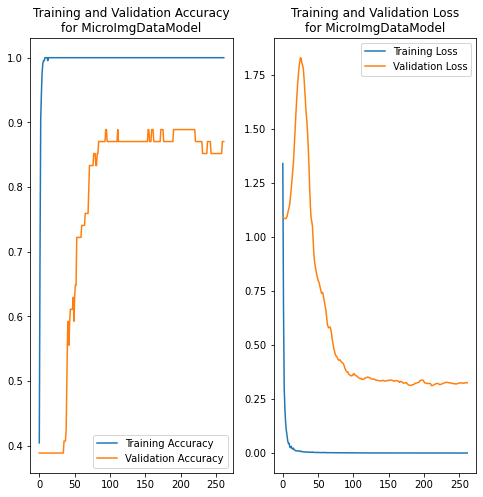

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title(f"Training and Validation Accuracy\nfor {model_name}")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title(f"Training and Validation Loss\nfor {model_name}")

plt.savefig(f"{log_dir}/{model_name}_training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [11]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModel/assets
